<a href="https://colab.research.google.com/github/sushirito/ArsenicFR/blob/main/Dialysis_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

,run,t_hr,C_meas_mg_per_L,C_adj_mg_per_L,V_bath_mL,V_bath_L,mass_mg,mass_cum_mg
0,1,16.0,1.04,35.0,336.538462,0.336538,0.350,0.350
1,2,22.0,0.58,18.5,318.965517,0.318966,0.185,0.535
2,3,40.0,0.52,16.4,315.384615,0.315385,0.164,0.699


{'M0_hat_mg': np.float64(0.9961032941162604), 'M0_95CI': [np.float64(0.3347283633219057), np.float64(1.6574782249106152)], 'k_hat_hr^-1': np.float64(0.03095931344624163), 'k_95CI': [np.float64(-0.0025643818708457194), np.float64(0.06448300876332898)], 't_half_hr': np.float64(22.388971311122255), 't_half_95CI': [np.float64(10.749299603931215), nan], 'R2': np.float64(0.943451352025503)}


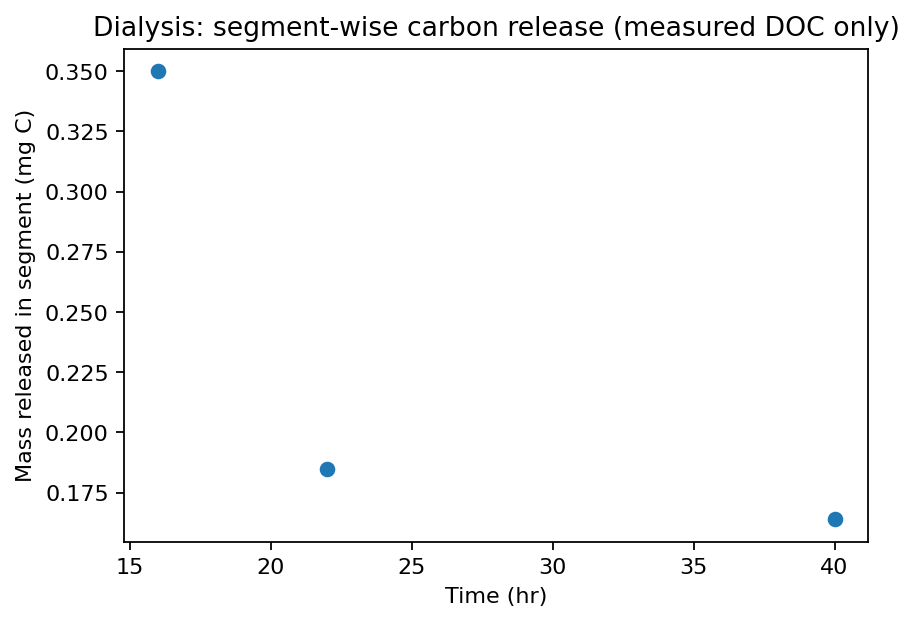

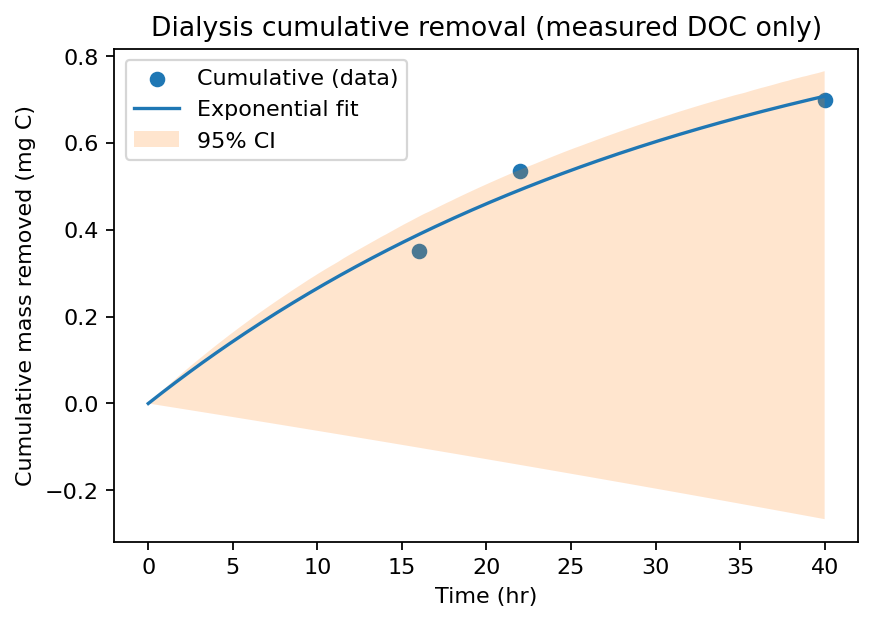

{'V_bath_typ_mL': 318.9655172413793, 'Predicted_mass_next_6hr_mg': np.float64(0.04894591199691041), 'Threshold_mg': 0.03189655172413793, 'Stop_now': False}


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Make plots a bit sharper
plt.rcParams["figure.dpi"] = 160

# %%
# ----------------------------
# 1) Enter your data
# ----------------------------
# Each row is a finished dialysis segment measured on a fresh external bath
# C_meas_mg_per_L = measured DOC of that bath (mg C/L)
# C_adj_mg_per_L  = your prior "volume-adjusted" value that you computed
# t_hr            = cumulative time when that segment ended

V_inside_mL = 10.0  # internal cassette volume

data = [
    {"run": 1, "t_hr": 16.0, "C_meas_mg_per_L": 1.04, "C_adj_mg_per_L": 35.0},
    {"run": 2, "t_hr": 22.0, "C_meas_mg_per_L": 0.58, "C_adj_mg_per_L": 18.5},
    {"run": 3, "t_hr": 40.0, "C_meas_mg_per_L": 0.52, "C_adj_mg_per_L": 16.4},
]

df = pd.DataFrame(data)

# ----------------------------
# 2) Back-calc the external bath volume for each segment
# ----------------------------
# V_bath = (C_adj / C_meas) * V_inside
df["V_bath_mL"] = (df["C_adj_mg_per_L"] / df["C_meas_mg_per_L"]) * V_inside_mL
df["V_bath_L"]  = df["V_bath_mL"] / 1000.0

# ----------------------------
# 3) Mass released per segment and cumulative mass
# ----------------------------
# mass_i = C_meas_i * V_bath_i
df["mass_mg"]     = df["C_meas_mg_per_L"] * df["V_bath_L"]
df = df.sort_values("t_hr").reset_index(drop=True)
df["mass_cum_mg"] = df["mass_mg"].cumsum()

display(df)

# %%
# ----------------------------
# 4) Fit cumulative mass to first-order washout
# ----------------------------
# Model: M_cum(t) = M0_hat * (1 - exp(-k * t))
def M_cum_model(t, M0_hat, k):
    return M0_hat * (1.0 - np.exp(-k * t))

t = df["t_hr"].to_numpy()
y = df["mass_cum_mg"].to_numpy()

# Simple initial guesses
M0_guess = float(df["mass_cum_mg"].iloc[-1])
k_guess  = 0.03

popt, pcov = curve_fit(M_cum_model, t, y, p0=[M0_guess, k_guess], maxfev=20000)
M0_hat, k_hat = popt
perr = np.sqrt(np.diag(pcov))
z = 1.959963984540054  # 95%

M0_lo, M0_hi = M0_hat - z*perr[0], M0_hat + z*perr[0]
k_lo,  k_hi  = k_hat - z*perr[1],  k_hat + z*perr[1]

t_half = np.log(2.0)/k_hat if k_hat > 0 else np.nan
t_half_lo = np.log(2.0)/k_hi if k_hi > 0 else np.nan
t_half_hi = np.log(2.0)/k_lo if k_lo > 0 else np.nan

# R^2 for the fit
yhat = M_cum_model(t, *popt)
ss_res = np.sum((y - yhat)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

print({
    "M0_hat_mg": M0_hat,
    "M0_95CI": [M0_lo, M0_hi],
    "k_hat_hr^-1": k_hat,
    "k_95CI": [k_lo, k_hi],
    "t_half_hr": t_half,
    "t_half_95CI": [t_half_lo, t_half_hi],
    "R2": r2
})

# %%
# ----------------------------
# 5) Plot A: per-interval mass vs time
# ----------------------------
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(df["t_hr"], df["mass_mg"])
ax.set_xlabel("Time (hr)")
ax.set_ylabel("Mass released in segment (mg C)")
ax.set_title("Dialysis: segment-wise carbon release (measured DOC only)")
plt.show()

# %%
# ----------------------------
# 6) Plot B: cumulative mass with exponential fit and 95% band
# ----------------------------
# Confidence band by parameter sampling
rng = np.random.default_rng(0)
try:
    draws = rng.multivariate_normal(mean=popt, cov=pcov, size=1000)
except np.linalg.LinAlgError:
    draws = np.column_stack([
        rng.normal(M0_hat, np.sqrt(pcov[0,0]), 1000),
        rng.normal(k_hat,  np.sqrt(pcov[1,1]), 1000),
    ])

tgrid = np.linspace(0, float(df["t_hr"].max()), 300)
Y = np.array([M_cum_model(tgrid, *theta) for theta in draws])
lo = np.percentile(Y, 2.5, axis=0)
hi = np.percentile(Y, 97.5, axis=0)
yfit = M_cum_model(tgrid, *popt)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(df["t_hr"], df["mass_cum_mg"], label="Cumulative (data)")
ax.plot(tgrid, yfit, label="Exponential fit")
ax.fill_between(tgrid, lo, hi, alpha=0.20, label="95% CI")
ax.set_xlabel("Time (hr)")
ax.set_ylabel("Cumulative mass removed (mg C)")
ax.set_title("Dialysis cumulative removal (measured DOC only)")
ax.legend()
plt.show()

# %%
# ----------------------------
# 7) Optional: simple stop rule using instrument LoD
# ----------------------------
# Define the instrument LoD in mg/L for DOC and a typical bath volume in mL.
# The rule says: stop when the predicted mass removed in the next segment is below LoD * V_bath_typ
LoD_mg_per_L   = 0.10   # edit if you know your DOC LoD
V_bath_typ_mL  = df["V_bath_mL"].median()
V_bath_typ_L   = V_bath_typ_mL / 1000.0

def predict_next_segment_mass(t_start, t_len_hr, M0_hat, k_hat):
    # mass removed over [t_start, t_start + t_len_hr]
    return M0_hat * (np.exp(-k_hat*t_start) - np.exp(-k_hat*(t_start + t_len_hr)))

# Example: predict a future 6 hr segment starting at t = 40 hr
t_start = 40.0
t_len   = 6.0
m_pred  = predict_next_segment_mass(t_start, t_len, M0_hat, k_hat)
threshold = LoD_mg_per_L * V_bath_typ_L

print({
    "V_bath_typ_mL": V_bath_typ_mL,
    "Predicted_mass_next_6hr_mg": m_pred,
    "Threshold_mg": threshold,
    "Stop_now": bool(m_pred < threshold)
})


,run,t_hr,C_meas_mg_per_L,C_adj_mg_per_L,V_bath_mL,V_bath_L,mass_mg,mass_cum_mg
0,1,16.0,1.04,35.0,336.538462,0.336538,0.350,0.350
1,2,22.0,0.58,18.5,318.965517,0.318966,0.185,0.535
2,3,40.0,0.52,16.4,315.384615,0.315385,0.164,0.699


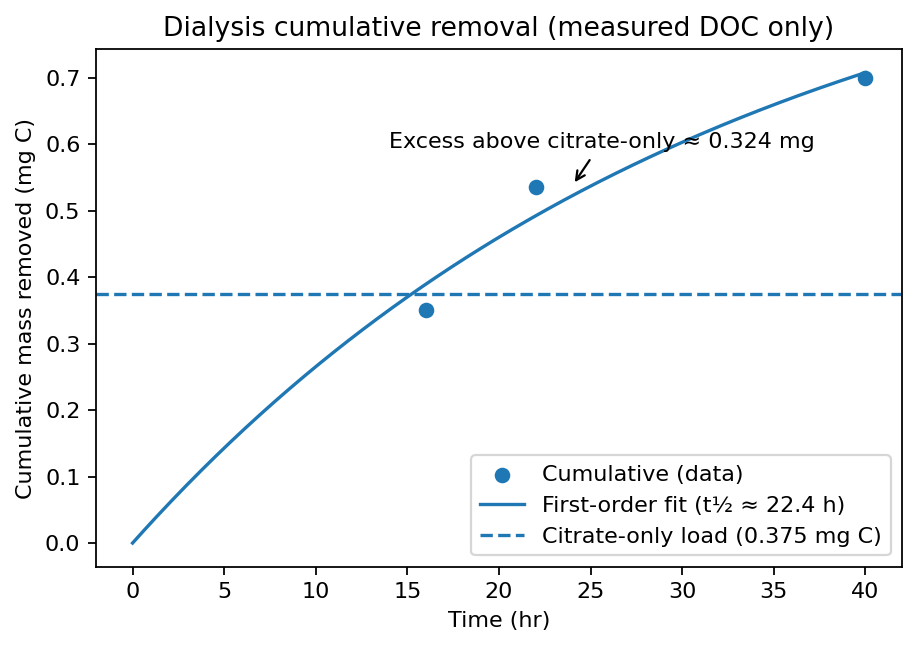

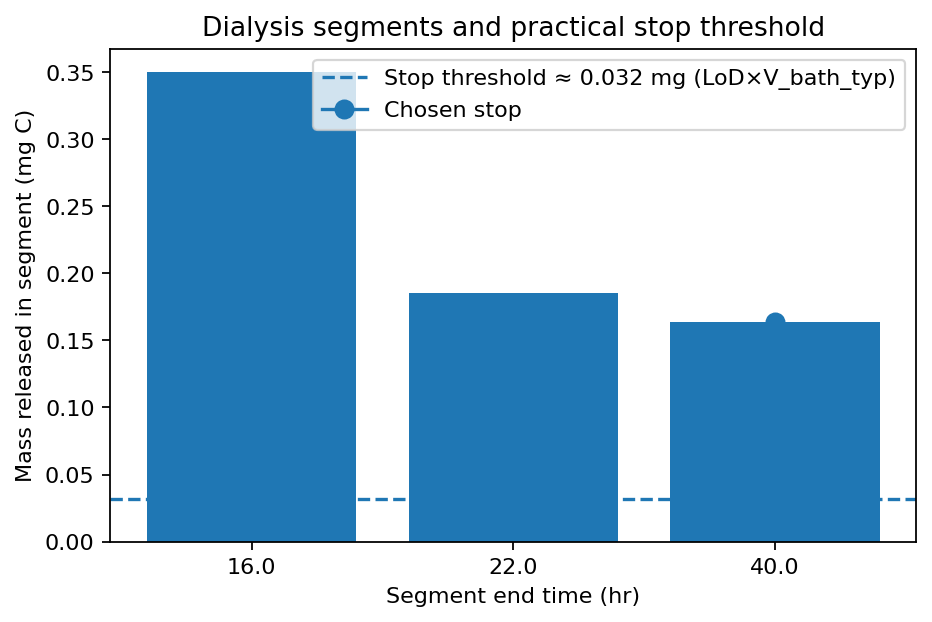

{'bath_volumes_mL': [336.5, 319.0, 315.4], 'segment_masses_mg': [0.35, 0.185, 0.164], 'citrate_only_load_mg': 0.375, 'fit': {'M0_hat_mg': 0.9961032941162604, 'k_hr^-1': 0.03095931344624163, 't_half_hr': 22.388971311122255}, 'excess_final_mg': 0.32400000000000007}


In [ ]:
# %% [markdown]
# Dialysis analysis — measured DOC only (no CI band, no background subtraction)
# Figures:
# 1) Cumulative mass vs time + first-order fit + citrate-only reference line
# 2) Segment mass bars + practical stop threshold (LoD × typical bath volume)

# %%
!pip -q install numpy pandas matplotlib scipy

# %%
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.rcParams["figure.dpi"] = 160

# ------------------ Inputs ------------------
V_inside_mL = 10.0
CITRATE_ONLY_M0_mg = 0.375  # 1.0 mg citrate × 0.375 C fraction

data = [
    {"run": 1, "t_hr": 16.0, "C_meas_mg_per_L": 1.04, "C_adj_mg_per_L": 35.0},
    {"run": 2, "t_hr": 22.0, "C_meas_mg_per_L": 0.58, "C_adj_mg_per_L": 18.5},
    {"run": 3, "t_hr": 40.0, "C_meas_mg_per_L": 0.52, "C_adj_mg_per_L": 16.4},
]
df = pd.DataFrame(data)

# Back-calc bath volume for each segment: V_bath = (C_adj / C_meas) * V_inside
df["V_bath_mL"] = (df["C_adj_mg_per_L"] / df["C_meas_mg_per_L"]) * V_inside_mL
df["V_bath_L"]  = df["V_bath_mL"] / 1000.0

# Segment mass and cumulative mass
df["mass_mg"] = df["C_meas_mg_per_L"] * df["V_bath_L"]
df = df.sort_values("t_hr").reset_index(drop=True)
df["mass_cum_mg"] = df["mass_mg"].cumsum()
display(df)

# First-order cumulative fit (no CI band)
def M_cum(t, M0_hat, k):
    return M0_hat * (1.0 - np.exp(-k*t))

t = df["t_hr"].to_numpy()
y = df["mass_cum_mg"].to_numpy()
popt, pcov = curve_fit(M_cum, t, y, p0=[y[-1], 0.03], maxfev=20000)
M0_hat, k_hat = popt
t_half = np.log(2)/k_hat if k_hat > 0 else np.nan

# ---------- Figure 1: cumulative vs time ----------
tgrid = np.linspace(0, t.max(), 300)
yfit  = M_cum(tgrid, *popt)
excess_final = y[-1] - CITRATE_ONLY_M0_mg  # mg above citrate-only

fig1, ax1 = plt.subplots(figsize=(6.5,4.2))
ax1.scatter(df["t_hr"], df["mass_cum_mg"], label="Cumulative (data)")
ax1.plot(tgrid, yfit, label=f"First-order fit (t½ ≈ {t_half:.1f} h)")
ax1.axhline(CITRATE_ONLY_M0_mg, linestyle="--", label="Citrate-only load (0.375 mg C)")
ax1.annotate(
    f"Excess above citrate-only ≈ {excess_final:.3f} mg",
    xy=(t.max()*0.6, (CITRATE_ONLY_M0_mg + y[-1])/2),
    xytext=(t.max()*0.35, y[-1]*0.85),
    arrowprops=dict(arrowstyle='->', lw=1)
)
ax1.set_xlabel("Time (hr)")
ax1.set_ylabel("Cumulative mass removed (mg C)")
ax1.set_title("Dialysis cumulative removal (measured DOC only)")
ax1.legend()
plt.show()

# ---------- Figure 2: segment masses + stop threshold ----------
LoD_mg_per_L = 0.10  # set your DOC LoD here
V_bath_typ_mL = df["V_bath_mL"].median()
stop_threshold_mg = LoD_mg_per_L * (V_bath_typ_mL / 1000.0)

fig2, ax2 = plt.subplots(figsize=(6.5,4.0))
ax2.bar(df["t_hr"].astype(str), df["mass_mg"])
ax2.axhline(stop_threshold_mg, linestyle="--",
            label=f"Stop threshold ≈ {stop_threshold_mg:.3f} mg (LoD×V_bath_typ)")
# mark first point below threshold (if any); else show last as decision point
below = np.where(df["mass_mg"].to_numpy() < stop_threshold_mg)[0]
stop_idx = below[0] if len(below) else len(df)-1
ax2.plot([stop_idx], [df.loc[stop_idx, "mass_mg"]], marker="o", markersize=8, label="Chosen stop")
ax2.set_xlabel("Segment end time (hr)")
ax2.set_ylabel("Mass released in segment (mg C)")
ax2.set_title("Dialysis segments and practical stop threshold")
ax2.legend()
plt.show()

print({
  "bath_volumes_mL": df["V_bath_mL"].round(1).tolist(),
  "segment_masses_mg": df["mass_mg"].round(3).tolist(),
  "citrate_only_load_mg": CITRATE_ONLY_M0_mg,
  "fit": {"M0_hat_mg": float(M0_hat), "k_hr^-1": float(k_hat), "t_half_hr": float(t_half)},
  "excess_final_mg": float(excess_final)
})
